# Model Optimization and Nonlinear Models

CSC/DSC 340 Week 5 Slides

Author: [Dr. Julie Butler](www.juliebutler.org)

Date Created: August 19, 2023

Last Modified: September 18, 2023

## Plan for the Week

**Monday**

Week 5 Pre-Class Homework and Week 4 In-Class Assignment Due

Lecture: Model Optimization and Nonlinear Models

Office Hours: 1pm - 3pm

**Tuesday**

Office Hours: 4pm - 6pm

**Wednesday**

Finish Lecture: Model Optimization and Nonlinear Models

Start Week 5 In-Class Assignment

Week 4 Post-Class Homework Due

**Thursday**

Office Hours: 12:30 - 2pm

**Friday**

In-Class Assignment Week 5

Problem Analysis Due Before Class (~1 page)

## Part 1: Hyperparameter Tuning

## Why do we need hyperparameter tuning?
* The values of the hyperparameters change the output of the model
* Bad hyperparameters lead to bad results

In [1]:
##############################
##         IMPORTS          ##
##############################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.datasets import fetch_california_housing

* New data set: California Housing
    * Goal: Predict the price a house will sale for (house price/100k) given information about the house
    * In-Class Week 5

In [2]:
# Print the features
fetch_california_housing().feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [3]:
##############################
##        IMPORT DATA       ##
##############################
X, y = fetch_california_housing(return_X_y = True)

In [4]:
##############################
##        SCALE DATA        ##
##############################
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

In [5]:
##############################
##     TRAIN-TEST SPLIT     ##
##############################
X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

MSE: 0.5207853811806975


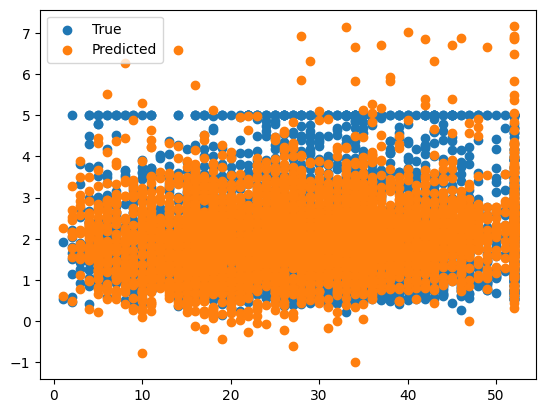

In [6]:
##############################
##        GOOD ALPHA        ##
##############################
ridge = Ridge(alpha=1e-15)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')
plt.legend()

MSE: 1.3166823615106975


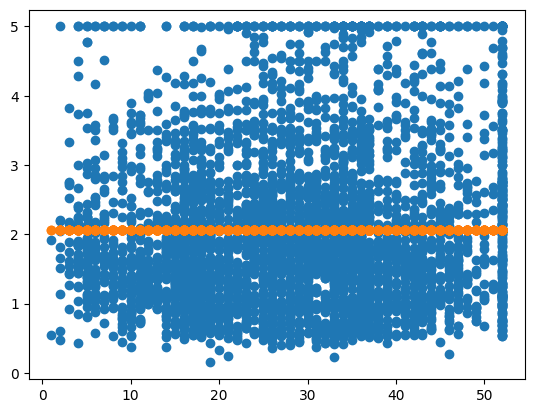

In [7]:
##############################
##        BAD ALPHA         ##
##############################
ridge = Ridge(alpha=1e15)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

## Methods for Hyperparameter Tuning

## Using Default Values
* Scikit-Learn sets the default value of $\alpha$ for ridge regression to 1.0, which is a reasonable high level of regularization

In [8]:
# Make the data set smaller (20k+ points in total)
# More points = more data to generate patterns BUT more run time
X = X[:1000]
y = y[:1000]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [9]:
%%time
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

CPU times: user 2.43 ms, sys: 5.11 ms, total: 7.54 ms
Wall time: 1.29 ms


MSE: 0.3596000507155571


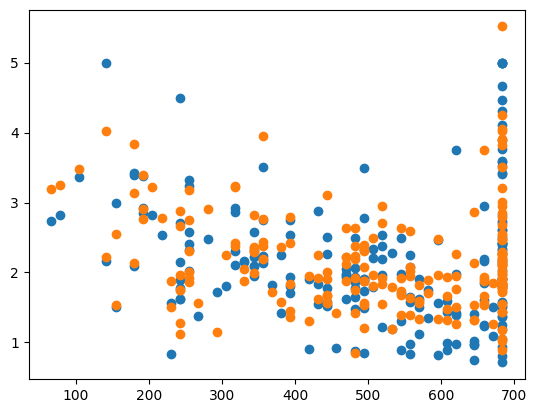

In [10]:
err = MSE(y_pred, y_test)
print("MSE:", err)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Fast and no need to modify the algorithm

### Cons
* Default value may not be the best value, but no test are done to check

## For Loop Tuning

* Use a for loop to check many different values for the hyperparameters
* Can use nested for loops if more than one hyperparamter

In [11]:
%%time
best_err = 1e4
best_alpha = None
for alpha in np.logspace(-15,4,1000):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    err = MSE(y_pred, y_test)
    
    if err < best_err:
        best_err = err
        best_alpha = alpha

CPU times: user 630 ms, sys: 5.05 ms, total: 635 ms
Wall time: 297 ms


MSE: 0.3552471269777846
CHOSEN ALPHA: 6.022541201461928e-15


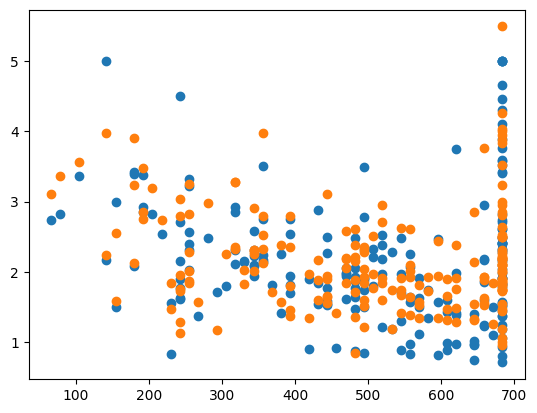

In [12]:
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print("CHOSEN ALPHA:", best_alpha)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Checks more than one value to find the best value
* Simple concept
* Short(ish) run times

### Cons
* Long piece of code
* Not checking all possible values of the hyperparameters

## GridSearchCV (Scikit-Learn)

* Scikit-Learn has several hyperparameter tuning implementation
* Grid search is a brute force algorithm which checks as many values as given 
    * If more than one hyperparameter, it checks every single possible combination
* "Same" test as for loops but gives much more information, but also takes longer

In [13]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {'alpha':np.logspace(-15,4,5000)}

ridge = Ridge()

grid_search = GridSearchCV(ridge, parameters,\
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'alpha': 0.20590302760544998}
CPU times: user 13.2 s, sys: 212 ms, total: 13.4 s
Wall time: 13.1 s


MSE: 0.3562628152996591
CHOSEN ALPHA: 0.20590302760544998


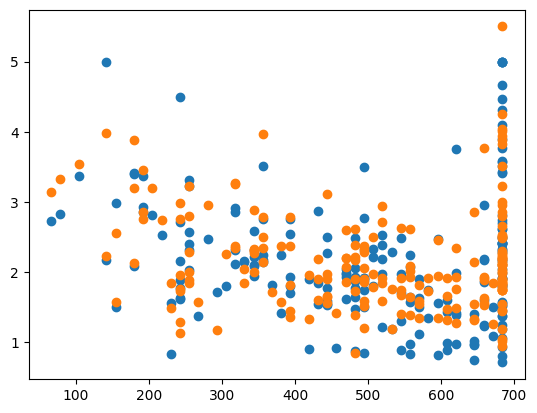

In [14]:
ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', grid_search.best_params_['alpha'])

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Only takes a few lines to implement
* Gives a lot of data once it is fit

### Cons
* Long run times
* Only searches the range of parameters given

## RandomizedSearchCV (Scikit-Learn)

* Tries `n_iter` randomly chosen values for the hyperparmeters taken from a given distribution (uniform in this case)

In [15]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

distributions = {'alpha':uniform(loc=0, scale=4)}

ridge = Ridge()

random_search = RandomizedSearchCV(ridge, distributions,\
                                   scoring='neg_mean_squared_error', n_iter=5000)
random_search.fit(X_train, y_train)

print(random_search.best_params_, random_search.best_score_)

{'alpha': 0.20597888239758078} -0.28856463563603973
CPU times: user 13.3 s, sys: 230 ms, total: 13.5 s
Wall time: 13.2 s


MSE: 0.35626318516764216
CHOSEN ALPHA: 0.20597888239758078


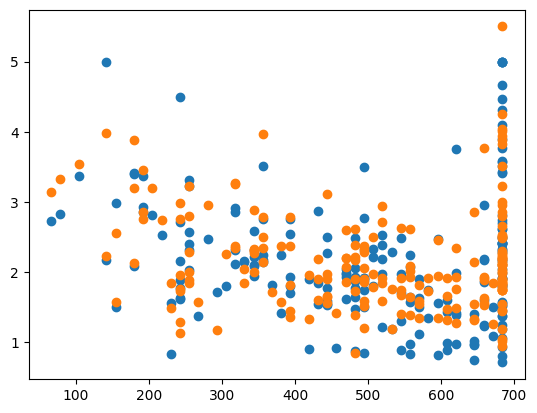

In [16]:
ridge = Ridge(alpha=random_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', random_search.best_params_['alpha'])

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Only takes a few lines to implement
* Gives a lot of data once it is fit

### Cons
* Long run times (depending on value of `n_iter`)
* Only searches a finite number of parameter combinations

## Bayesian Ridge Regression

* Finds the "most likely" value for $\alpha$ using Bayesian stastics
* Leaves no uncertainity that the best value was just not sampled

In [17]:
%%time
from sklearn.linear_model import BayesianRidge

bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)

print(bayesian_ridge.alpha_)

3.688440522864384
CPU times: user 5.58 ms, sys: 1.28 ms, total: 6.85 ms
Wall time: 1.68 ms


MSE: 0.3592175812997633
CHOSEN ALPHA: 3.688440522864384


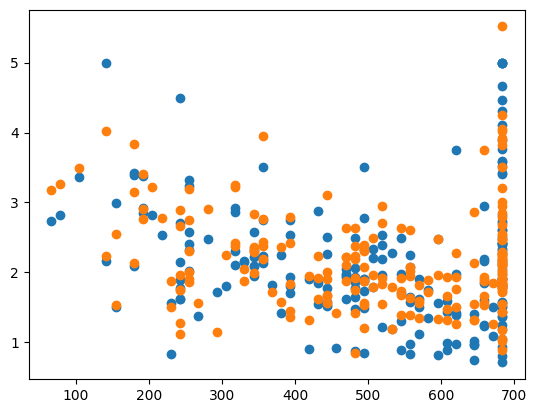

In [18]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', ridge.alpha_)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Only takes a few lines to implement
* Statical certainity that the given $\alpha$ value is the best value
* Short run times

### Cons
* Only valid for Bayesian ridge regression (linear model)

## Comparison of $\alpha$, Accuracy, and Run Time
* Exact values depend on the train-test split and RandomizedSearch results; these values were taken from one run

In [19]:
labels = ['default', 'for loops', 'GridSearchCV', 'RandomizedSearchCV', 'Bayesian']
alphas = [1.0, 1e-15, 769.79, 3.99, 1.90]
mse = [0.23461613368850237, 0.2343672966024232, 0.23546465060931623, 0.23546192678932165, 0.23439940455100014]
run_times = [20.8/1000, 1.35, 57.7, 7*60+40, 1.18] #ms

Text(0.5, 0, 'Hyperparameter Tuning Method')

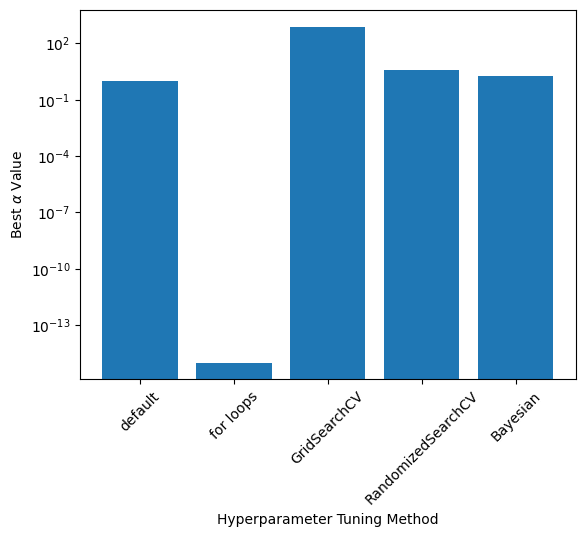

In [20]:
plt.bar(np.arange(0,len(labels)), alphas)
plt.yscale('log')
plt.xticks(np.arange(0,len(labels)), labels, rotation=45)
plt.ylabel(r"Best $\alpha$ Value")
plt.xlabel("Hyperparameter Tuning Method")

Text(0.5, 0, 'Hyperparameter Tuning Method')

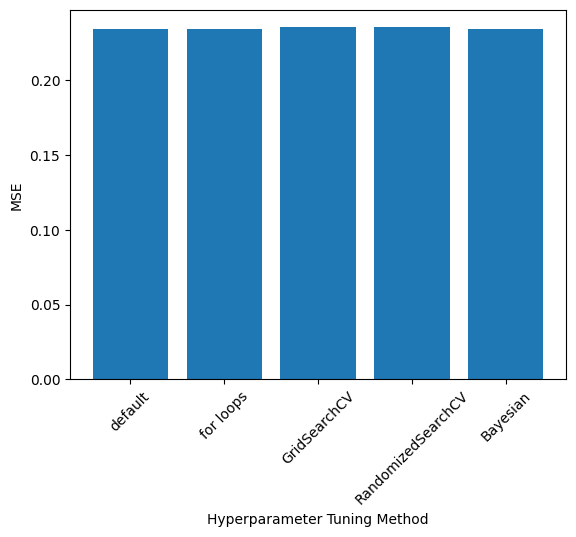

In [21]:
plt.bar(np.arange(0,len(labels)), mse)
plt.xticks(np.arange(0,len(labels)), labels, rotation=45)
plt.ylabel(r"MSE")
plt.xlabel("Hyperparameter Tuning Method")

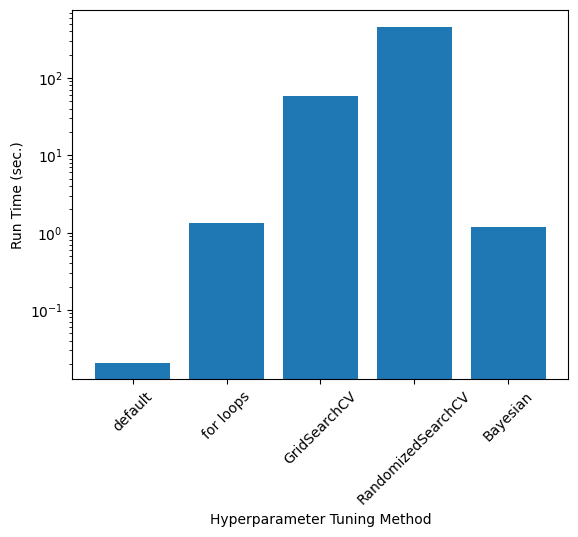

In [22]:
plt.bar(np.arange(0,len(labels)), run_times)
plt.xticks(np.arange(0,len(labels)), labels, rotation=45)
plt.ylabel(r"Run Time (sec.)")
plt.xlabel("Hyperparameter Tuning Method")
plt.yscale('log')

## Part 2: Feature Engineering

Feature engineering is the process of eliminating or altering given inputs in order to improve the model's predictions
* Design matrix/alter the inputs
* Remove features that are not useful
* Scaling the features or targets

In [23]:
import pandas as pd
import seaborn as sns

housing = fetch_california_housing()

housing_data = pd.DataFrame(housing.data, columns=housing.feature_names)

housing_data['target'] = housing.target

housing_data = housing_data.sample(1000)

Pairplots can give us initial ideas about the data set and and obvious relations

/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


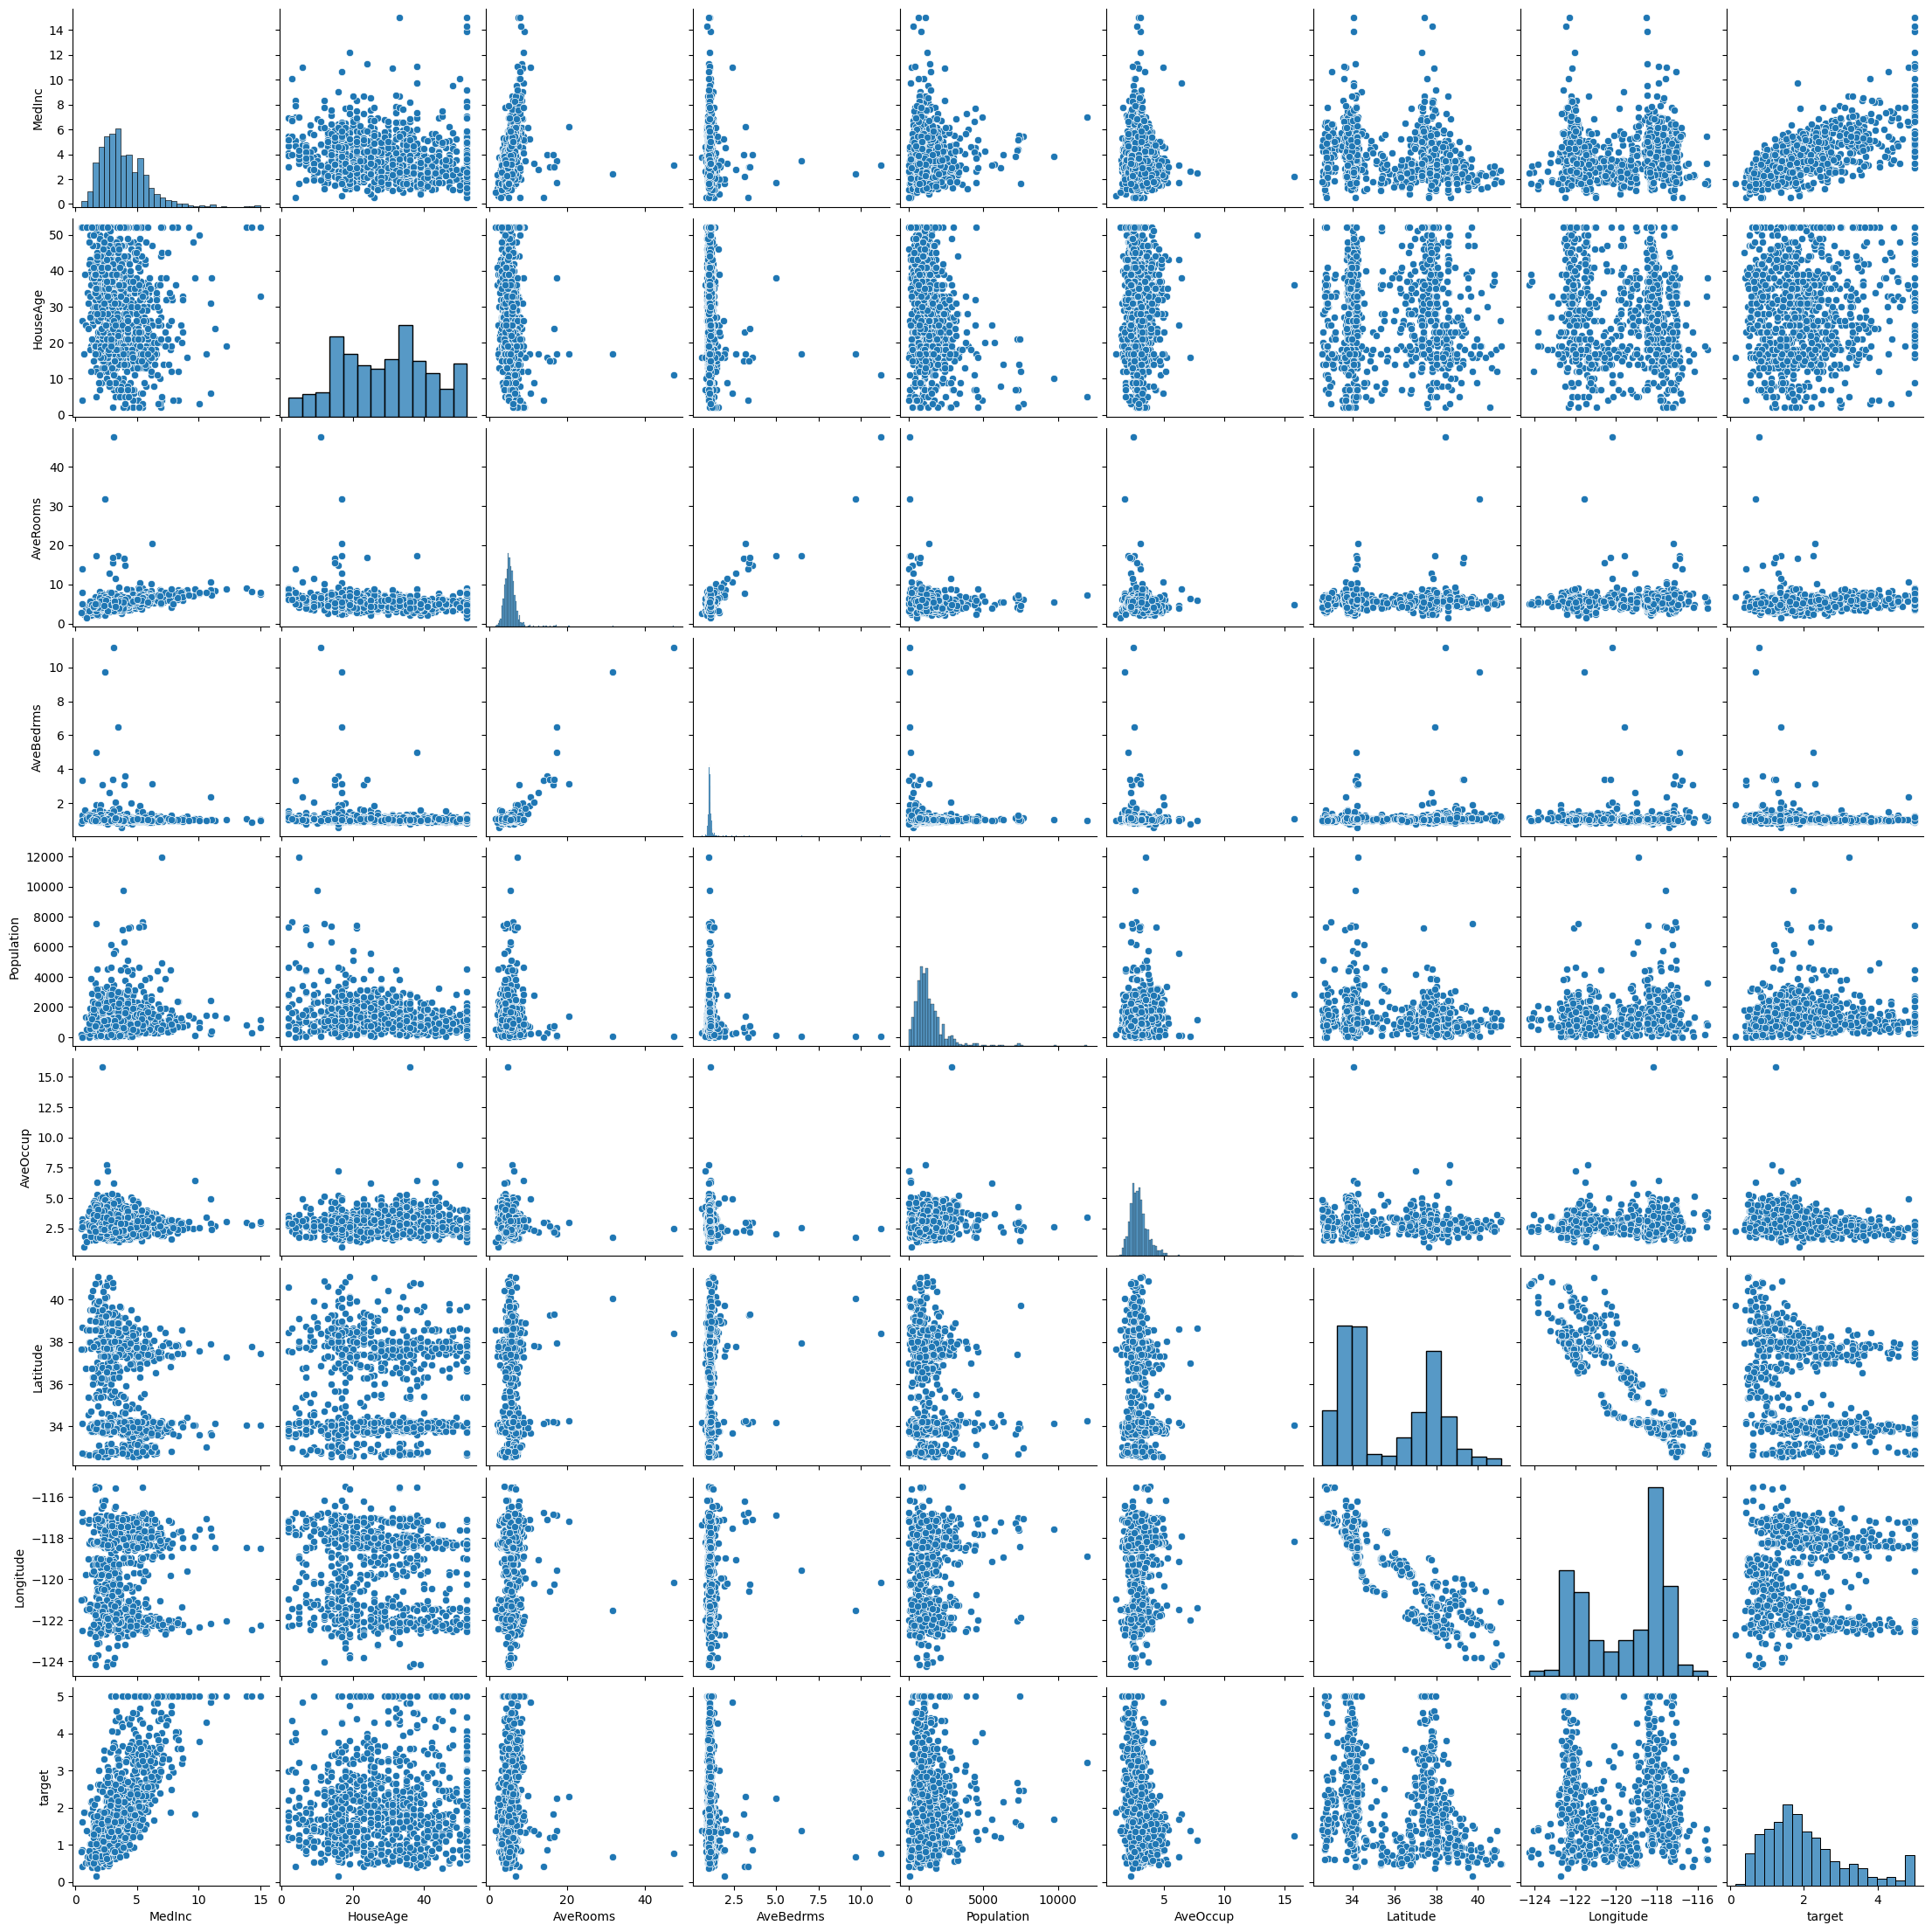

In [24]:
sns.pairplot(housing_data)

/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


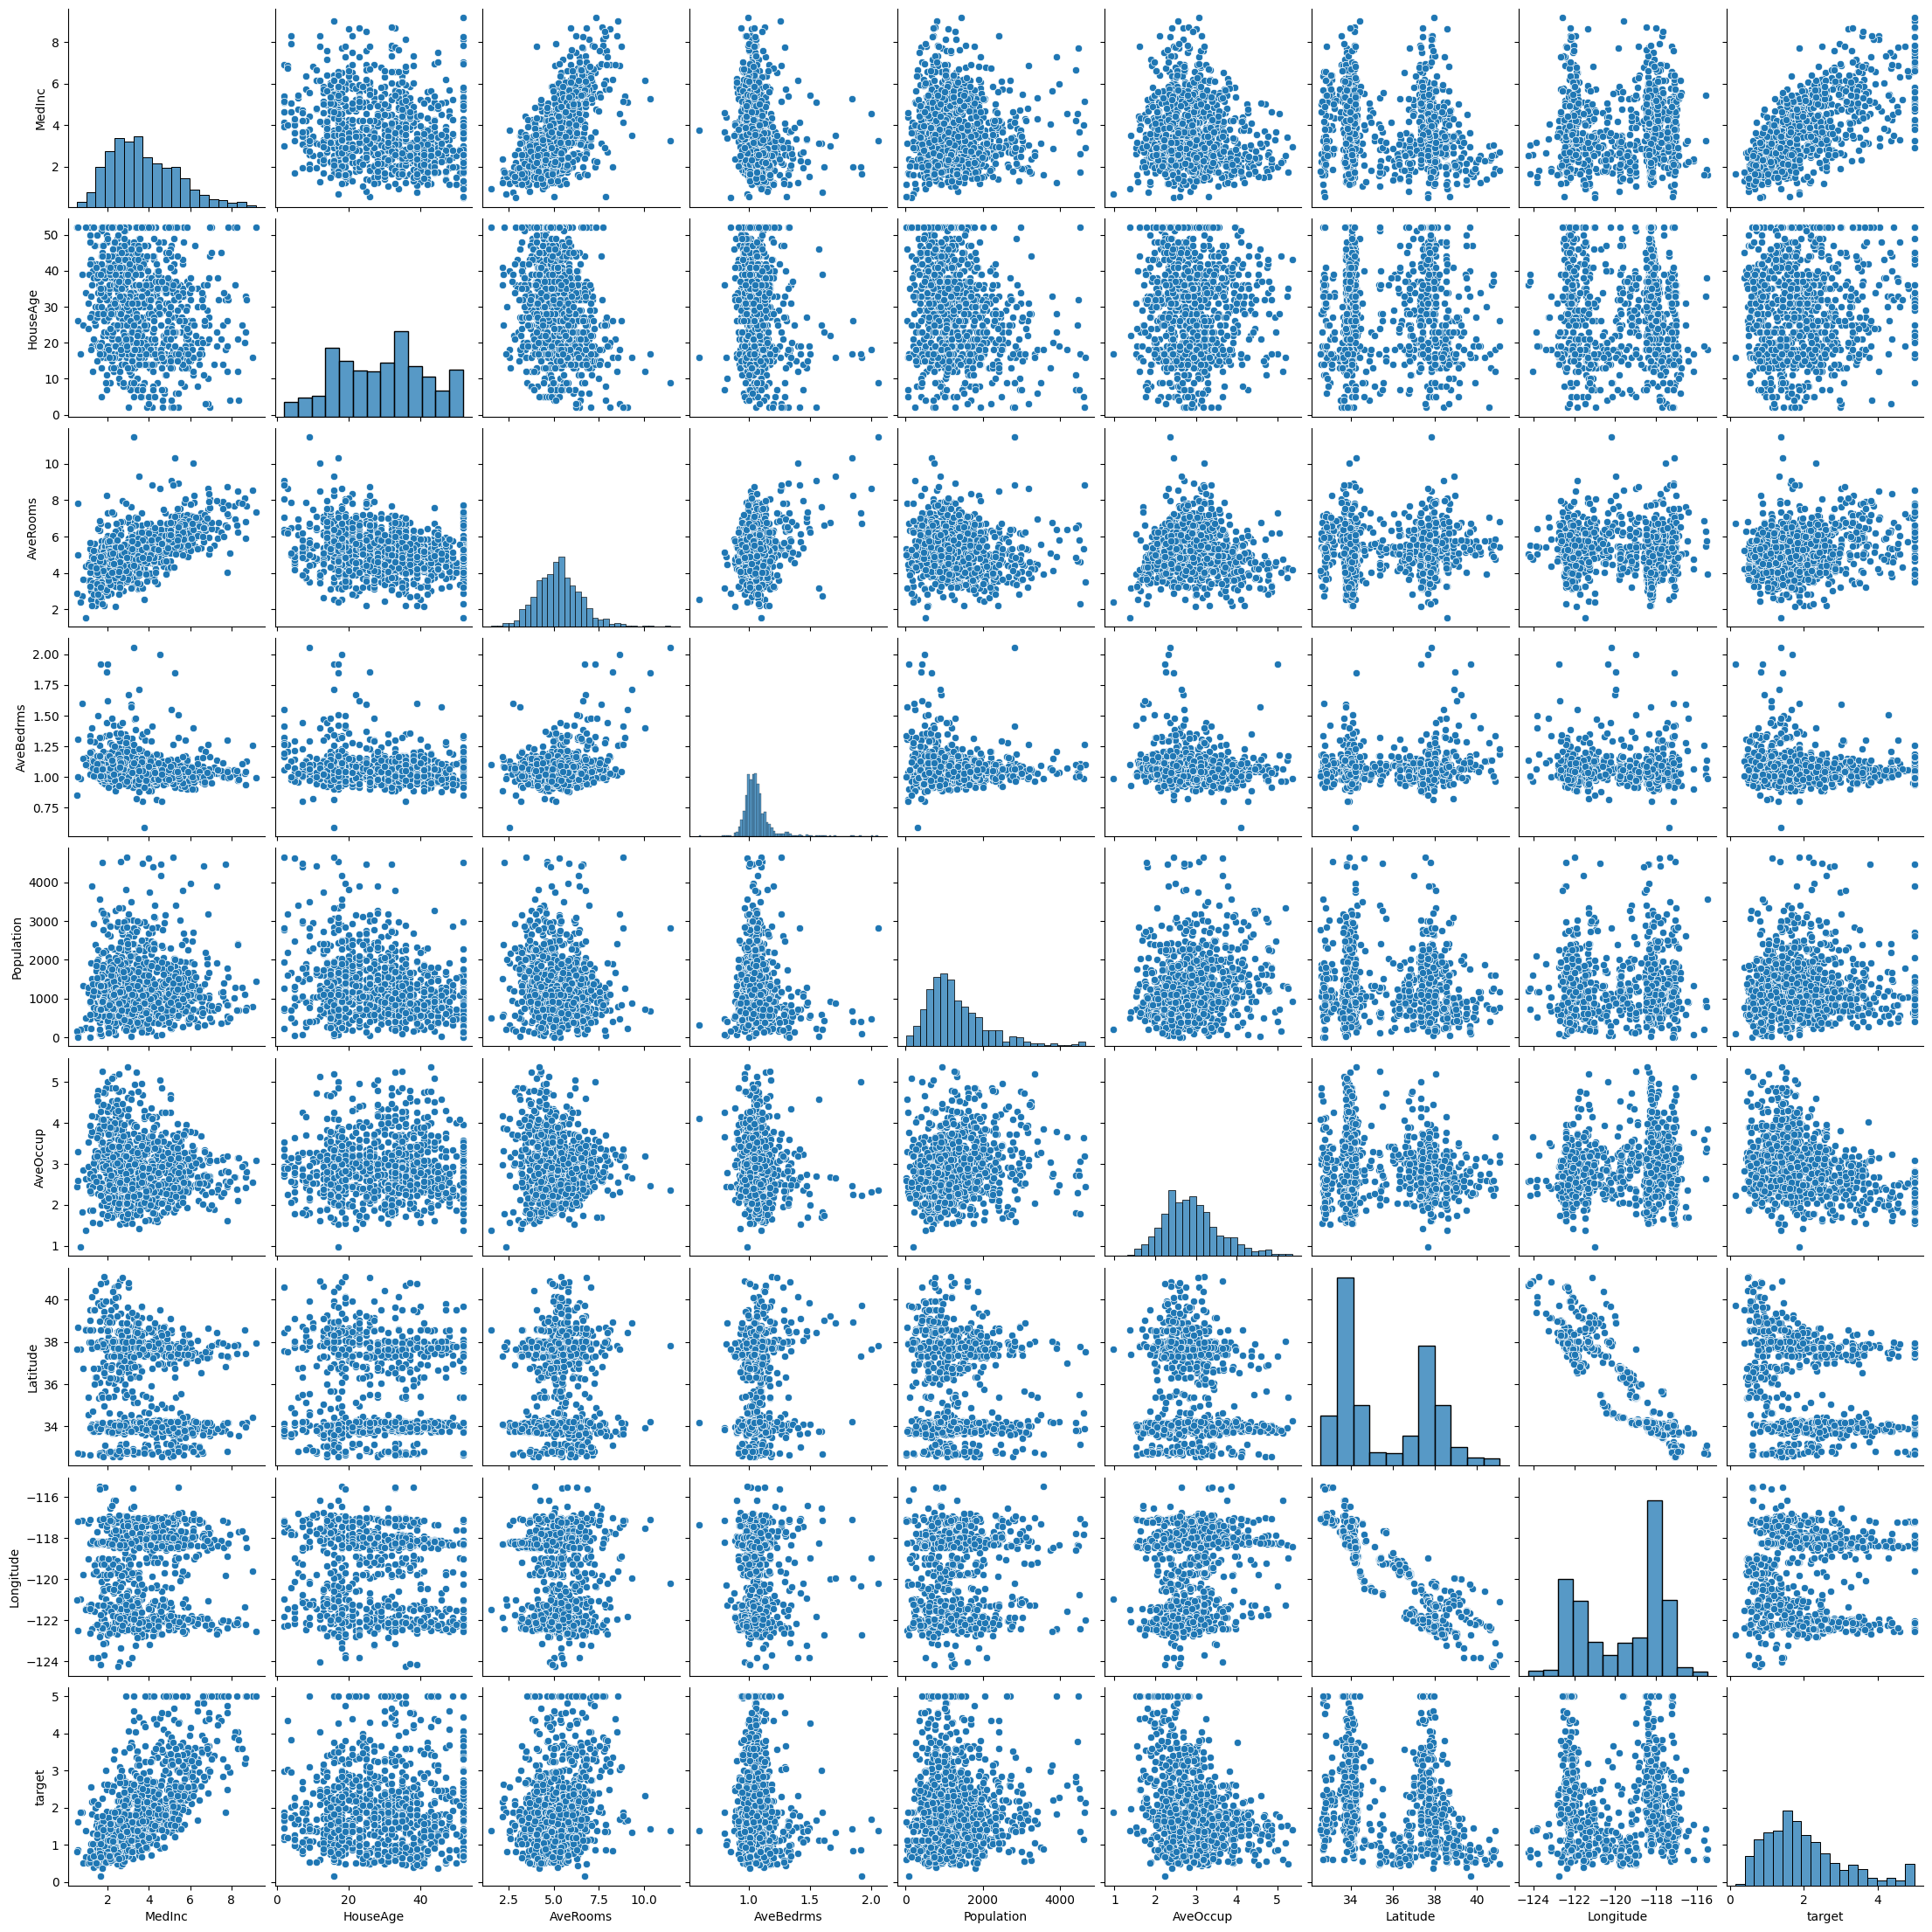

In [25]:
# Remove outliers from the data set and make the pairplot again

from scipy import stats

housing_data = housing_data[(np.abs(stats.zscore(housing_data)) < 3).all(axis=1)]

sns.pairplot(housing_data)

## Correlation Matrix

* Correlation score = $\sqrt{R2\ Score}$
* Values close to $\pm1$ means that the two feautures are linearly related

In [26]:
correlation_matrix = housing_data.corr()
correlation_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.176376,0.624278,-0.182821,-0.006504,-0.118286,-0.145364,0.051990,0.671977
HouseAge,-0.176376,1.000000,-0.273970,-0.171407,-0.250648,-0.000109,0.007118,-0.100684,0.077059
AveRooms,0.624278,-0.273970,1.000000,0.292713,-0.108061,-0.049828,0.077900,-0.022613,0.254047
AveBedrms,-0.182821,-0.171407,0.292713,1.000000,-0.080388,-0.102396,0.132675,-0.047917,-0.121542
Population,-0.006504,-0.250648,-0.108061,-0.080388,1.000000,0.170063,-0.097118,0.070431,0.019527
AveOccup,-0.118286,-0.000109,-0.049828,-0.102396,0.170063,1.000000,-0.198600,0.214724,-0.324090
Latitude,-0.145364,0.007118,0.077900,0.132675,-0.097118,-0.198600,1.000000,-0.931286,-0.198935
Longitude,0.051990,-0.100684,-0.022613,-0.047917,0.070431,0.214724,-0.931286,1.000000,0.006876
target,0.671977,0.077059,0.254047,-0.121542,0.019527,-0.324090,-0.198935,0.006876,1.000000


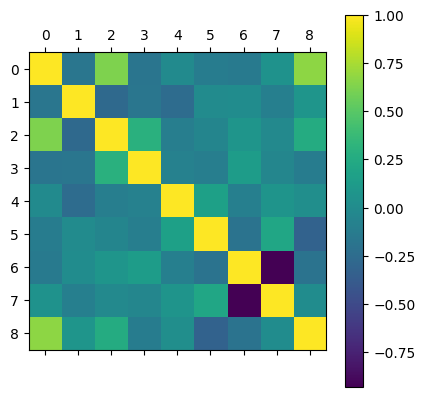

In [27]:
plt.matshow(correlation_matrix)
plt.colorbar()

## LASSO Regression for Feature Selection

In [28]:
lasso = Lasso()
lasso.fit(X,y)
ypred = lasso.predict(X)
print(MSE(ypred,y))
lasso.coef_

0.638471842835069


array([ 0.06161184, -0.        ,  0.        , -0.        ,  0.00011673,
       -0.        ,  0.        ,  0.        ])

## Accuracy with All Data (Scaled)

In [29]:
X = housing_data.drop(columns=['target'])
y = housing_data['target']

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)

print('MSE:', MSE(y_pred, y_test))

MSE: 0.44933334607255193


## Accuracy with Most Correlated Features (Scaled)

In [30]:
X_corr = housing_data[['MedInc', 'HouseAge', 'AveRooms']]
y = housing_data['target']

scaler = StandardScaler()
scaler.fit(X_corr)
Z = scaler.transform(X_corr)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)

print('MSE:', MSE(y_pred, y_test))

MSE: 0.5527782905639612


* Automate the dimensionality reduction with unsupervised learning (next week!)

## Part 3: Nonlinear Models

## Kernel Ridge Regression (KRR)

* All previous models we have studied have been linear--capable of modeling linear patterns
    * Design matrices can only add some much functions
* Many data sets will have a nonlinear pattern and thus we need a nonlinear model
    * Kernel ridge regression (KRR)
    * Support vector machines (SVMs)
    * Neural Networks

### Kernel Functions
* Scikit-Learn kernels are found [here](https://scikit-learn.org/stable/modules/metrics.html)

    * Linear: $k(x,y) = x^Ty$
    * Polynomial: k(x,y) = $(\gamma x^Ty+c_0)^d$
    * Sigmoid: $k(x,y) = tanh(\gamma x^Ty+c_0)$
    * Radial Basis Function (RBF): $k(x,y) = exp(-\gamma||x-y||_2)$

* Inputs to KRR algorithm are modified by the kernel function, thus giving the method nonlinearuty $\longrightarrow$ kernel methods/trick allows linear methods to solve nonlinear problems
    * Kernel ridge regression is just ridge regression with the inputs modified by the kernel function

### KRR Equations

* Form of predictions: $\hat{y}(x) = \sum_{i=1}^m \theta_ik(x_i,x)$
* Loss function:$J(\theta) = MSE(y,\hat{y}) + \frac{\alpha}{2}\sum_{i=1}^n\theta_i^2$
* Optimized parameters: $\theta = (\textbf{K}-\alpha\textbf{I})^{-1}y$
    * $\textbf{K} = k(x_i, x_j)$

### Hyperparameter Tuning with Many Hyperparameters
* KRR has the same hyperparameter as ridge regression: $\alpha$
* Each kernel function has 0-3 hyperparameters
* The choice of kernel function is a hyperparameter
* Hyperparameter tuning becomes more important as the number of hyperparameters in the model increases

## Housing Data with Kernel Ridge Regression

In [31]:
from sklearn.kernel_ridge import KernelRidge

X,y = fetch_california_housing(return_X_y=True)

X = X[:500]
y = y[:500]

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

krr = KernelRidge()
krr.fit(X_train, y_train)
y_pred = krr.predict(X_test)
print("MSE:", MSE(y_pred, y_test))

MSE: 4.105741823609707


In [32]:


distributions = {'alpha':uniform(loc=0, scale=4), 'kernel':['linear', \
                                                            'polynomial', 'rbf', \
                                                            'sigmoid', 'laplacian'], \
                 'gamma':uniform(loc=0, scale=4),\
                'degree':np.arange(0,10), 'coef0':uniform(loc=0, scale=4)}

krr = KernelRidge()

random_search = RandomizedSearchCV(krr, distributions,\
                                   scoring='neg_mean_squared_error', n_iter=50)
random_search.fit(X_train, y_train)
print(random_search)
print(random_search.best_params_, random_search.best_score_)

KeyboardInterrupt: 

In [45]:
X,y = fetch_california_housing(return_X_y=True)

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

In [46]:
# Using the best parameters from through one run of the 
# RandomizedSearchCV method above
krr = KernelRidge(alpha= 0.35753693232459094, coef0= 3.2725118241858264, degree= 9, gamma= 0.14696609545731532, kernel= 'laplacian')
krr.fit(X_train, y_train)
y_pred = krr.predict(X_test)
print('MSE:', MSE(y_pred, y_test))

MSE: 0.23499324697787755


In [47]:
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)
print('MSE:', MSE(y_pred, y_test))

MSE: 0.5242651488478602
